# CSE332 - Introduction to Visualization

## Lab 3 Report by Zhanarbek Osmonaliev
This lab aims to display more advanced visualization techniques, accompanied by more complex data analysis.
The notebook provides general information about each visualization and shallow breakdown of the algorithmic process.

### 1. Load the dataset and necessary libraries.
`data` will be used to hold our dataset variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import scipy.stats as ss

filename = "NYPD_Complaint_Data_Filtered.csv"
data_raw = np.genfromtxt(filename, dtype=None, delimiter=',', skip_header=True, usecols=range(17),filling_values=None, encoding='UTF-8')
data = np.empty((11065, 8), dtype=object)


In [2]:
age_converter = {'<18': 18.0, '18-24': 22.0, '25-44': 35.0, '45-64': 55, '65+': 65}

### 2. Prepare the data
Only necessary attributes will be loaded into `data`. They are 8 attributes in total.

In [3]:
for i, row in enumerate(data_raw):
    
    start_date = [int(i) for i in row[1].split('/')]
    end_date = [int(i) for i in row[3].split('/')]
    precinct = row[0]
    law_cat = row[5]
    suspect_age = row[7]
    victim_age = row[10]
    suspect_sex = 'M' if row[9] == 'M' else 'F'
    victim_sex = 'M' if row[12] == 'M' else 'F'
    
    entry = np.array([precinct,law_cat, str(start_date[1]), str(start_date[0]), suspect_age, suspect_sex, victim_age, victim_sex])
    data[i] = entry
    
# np.savetxt("NYPD_Complaint_Data_Processed_1.csv", data, delimiter=",",fmt="%.18s", header="precinct,law_category,crime_day,crime_month,suspect_age,suspect_sex,victim_age,victim_sex")    

### 3. Correlation Matrix
Since all my attributes are categorical (nominal), I used a correlation formula different from Pearson's, that is
Cramer's V formula. The difference is that the ratio will be in range of [0,1].

In [4]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

Once the necessary functions are initialized, we proceed to calculation process. Since the loaded data is in the
`String` form, we must encode it accordingly, be in just ordinal encoding or one-hot encoding.

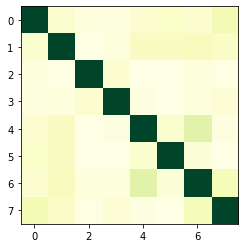

In [5]:
size = entry.size
matrix = np.ones((size,size))
labels = ["precinct","crime_law","crime_day","crime_month","suspect_age","suspect_sex","victim_age","victim_sex"]

for i in range(0, size):
    for j in range(i+1, size):
        x = data[:, i].reshape(data.shape[0])
        y = data[:, j].reshape(data.shape[0])
        correlation = cramers_v(x, y)
        matrix[i][j] = correlation
        matrix[j][i] = correlation

plt.imshow(matrix, cmap='YlGn')
plt.show()

output = np.empty((size*size, 3), dtype='object')
for i, row in enumerate(output):
    row[0] = labels[i//8]
    row[1] = labels[i%8]
    row[2] = str(int(matrix[i//8][i%8]*100))

# np.savetxt("correlation-matrix-data.csv", output, delimiter=",",fmt="%.15s", header="attribute, compared, correlation")


### 4. Parallel Coordinates Display
Parallel coordinates is a visualization technique used to plot individual data elements across many performance measures. Each of the measures corresponds to a vertical axis and each data element is displayed as a series of connected points along the measure/axes.  

Since the data has already been encoded, we just save it as it is. Further manipulations will be made in D3.JS.

In [6]:
## PARALLEL COORDINATES DISPLAY
print(data[1])
data[:, [0,1,2,3,4,5,6,7]] = data[:, [4,6,5,7,1,2,3,0]]
print(data[1])
# np.savetxt("parallel-coordinates-data.csv", data, delimiter=",",fmt="%.18s", header="suspect_age,victim_age,suspect_sex,victim_sex,crime_law,day_of_month,month,precinct")   

['5' 'FELONY' '28' '3' '25-44' 'M' '25-44' 'F']
['25-44' '25-44' 'M' 'F' 'FELONY' '28' '3' '5']


### 5. PCA Plot and Scree Plot
Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

I utilized external libraries to compute principal components of the dataset.

In [7]:
## PCA Plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
age_converter = {'<18': 1.0, '18-24': 2.0, '25-44': 3.0, '45-64': 4.0, '65+': 5.0}
law_converter = {"VIOLATION": 1.0, "MISDEMEANOR": 2.0, "FELONY": 3.0}
isMale = {"M": 1.0, "F": 0.0}
isFemale = {"M": 0.0, "F": 1.0}

dataframe = np.zeros((11065, 10),dtype='float')

for i,row in enumerate(data):
    entry = np.array([age_converter[row[0]],age_converter[row[1]],isMale[row[2]],isFemale[row[2]],isMale[row[3]],isFemale[row[3]],law_converter[row[4]], float(row[5]),float(row[6]), float(row[7])])
    dataframe[i] = entry
    
# np.savetxt("pca-plot-data-unprocessed.csv", dataframe, delimiter=",",fmt='%.2f', header="s_age,v_age,s_male,s_female,v_male,v_female,crime_law,day,month,precinct")


In [8]:
df = pd.read_csv('pca-plot-data-unprocessed.csv')
headers = ['s_age','v_age','s_male','s_female','v_male','v_female','crime_law','day','month','precinct']
x = df.loc[:, headers].values
x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = headers).head()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

np.set_printoptions(precision=4,suppress=True)

vectors = np.transpose(pca.components_)
vectors = vectors*100
vectors[8] = vectors[8]*100
indexes = [0,1,7]
for i in indexes:
    vectors[i] = vectors[i]*10
    
labels = [['s_age'],['v_age'],['s_male'],['s_female'],['v_male'],['v_female'],['crime_law'],['day'],['month'],['precinct']]
vectors = np.concatenate((vectors,labels),axis=1)

print(vectors)
print(pca.explained_variance_)

# np.savetxt("../processed/biplot-data.csv", vectors, delimiter=",",fmt='%.15s', header="x,y,attr")
# principalDf.to_csv('pca-plot-data.csv', sep=',', encoding='utf-8',index=False)

[['-29.72277285668492' '-8.32033651991512' 's_age']
 ['-98.37488168123681' '94.4134719946608' 'v_age']
 ['-39.86650443015714' '-57.45113086643988' 's_male']
 ['39.86650443015718' '57.451130866439904' 's_female']
 ['-56.28747480496157' '40.48444421004076' 'v_male']
 ['56.28747480496159' '-40.48444421004076' 'v_female']
 ['-15.362035459224032' '-4.746125199646702' 'crime_law']
 ['-22.676011069721014' '26.520653978792723' 'day']
 ['42.59378603847875' '-116.60563997495952' 'month']
 ['11.7404357751136' '0.06722046502712128' 'precinct']]
[2.062  2.0057]


### 6. MDS Display (Euclidean Distance)
MDS is a non-linear technique for embedding data in a lower-dimensional space. t maps points residing in a higher-dimensional space to a lower-dimensional space while preserving the distances between those points as much as possible.

I used an external library to compute the MDS. The dataset was reduced to 2,000 datapoints from 11,065 points, as
it was tedious to calculate MDS for high number of vectors.


In [9]:
### MDS Display Euclidean Distance
from sklearn.manifold import MDS
mds = MDS(random_state=0)
np.random.shuffle(dataframe)
X = dataframe[:2000,:]
X_transform = mds.fit_transform(X)
print(np.amin(X_transform[:,0]))
print(np.amax(X_transform[:,0]))
print(np.amin(X_transform[:,1]))
print(np.amax(X_transform[:,1]))
# np.savetxt("mds-display-euclidean-data.csv", X_transform, delimiter=",",fmt='%.2f', header="x,y")

-20.609676601424084
23.44241954398675
-24.300072980795303
19.820463211477822


### 6. MDS Display (1 - Correlation)
MDS is a non-linear technique for embedding data in a lower-dimensional space. t maps points residing in a higher-dimensional space to a lower-dimensional space while preserving the distances between those points as much as possible.

Similarly, I used an external library to compute the MDS. The dataset was reduced to 2,000 datapoints from 11,065 points, as
it was tedious to calculate MDS for high number of vectors.

In [10]:
### MDS Display Correlation Distance

temp = np.ones(matrix.shape)
X = np.subtract(matrix, temp)
mds = MDS(dissimilarity='precomputed', random_state=0)
X_transform = mds.fit_transform(X)
labels = np.array([["precinct"],["crime_law"],["crime_day"],["crime_month"],["suspect_age"],["suspect_sex"],["victim_age"],["victim_sex"]])
X_transform = np.concatenate((X_transform,labels),axis=1)
print(X_transform)
np.savetxt("mds-display-correlation-data.csv", X_transform, delimiter=",",fmt='%.15s',header='x,y,attr')

[['-0.40574514980347165' '0.4542786600173975' 'precinct']
 ['0.1808779969944533' '0.6178903566560587' 'crime_law']
 ['0.7655477781347767' '-0.2289888193703256' 'crime_day']
 ['-0.5242422631897821' '-0.13607805157452088' 'crime_month']
 ['0.3850532616108182' '0.1410208710139011' 'suspect_age']
 ['-0.08313238713572182' '-0.004584939255510845' 'suspect_sex']
 ['-0.6060558968863339' '-0.3999833254877666' 'victim_age']
 ['0.287696660275261' '-0.4435547519992337' 'victim_sex']]


### Screeplot for PCA
Screeplot data was obtained by calculating top 10 eigenvectors and deriving their related variance.

In [11]:
### SCREEPLOT FOR PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

array = np.array(["{:.2f}".format(x * 100) for x in pca.explained_variance_ratio_])
columns = np.array(['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
array = array.reshape((array.size, 1))
columns = columns.reshape((columns.size, 1))
scree_data = np.concatenate((columns, array), axis=1)

# np.savetxt("scree-plot-data.csv", scree_data, delimiter=",",fmt='%.10s',header='PC,variance')
